In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# 1. Cargar el dataset MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Conjuntos de datos de entrenamiento y prueba
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
# 2. Visualizar ejemplos de imágenes y sus etiquetas
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
# Obtener un lote de imágenes
dataiter = iter(trainloader)
images, labels = next(dataiter) 

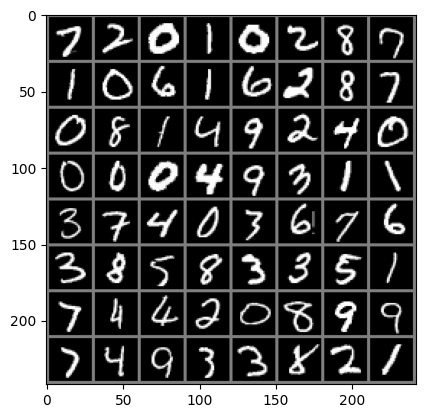

    7     2     0     1     0     2     8     7


In [9]:
# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(8)))

In [10]:
# 3. Definir la MLP (Multilayer Perceptron)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Capa de entrada a primera capa oculta
        self.fc2 = nn.Linear(128, 128)    # Segunda capa oculta
        self.fc3 = nn.Linear(128, 10)     # Capa de salida con 10 neuronas
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplanar la imagen 28x28 en un vector de 784
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [11]:
# 4. Definir el modelo, la función de pérdida y el optimizador
model = MLP()
criterion = nn.CrossEntropyLoss()  # Entropía cruzada categórica
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam

In [12]:
# 5. Entrenamiento del modelo
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()  # Resetear gradientes
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader)}')

Epoch 1/5, Loss: 1.6845268806668996
Epoch 2/5, Loss: 1.5535496309367833
Epoch 3/5, Loss: 1.5287874588834198
Epoch 4/5, Loss: 1.517679131488556
Epoch 5/5, Loss: 1.5108126705643465


In [13]:
# 6. Evaluación del modelo en el conjunto de prueba
correct = 0
total = 0
all_preds = []
all_labels = []

In [14]:
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Obtener el índice con la probabilidad más alta
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

In [15]:
print(f'Precisión en el conjunto de prueba: {100 * correct / total}%')

Precisión en el conjunto de prueba: 95.01%


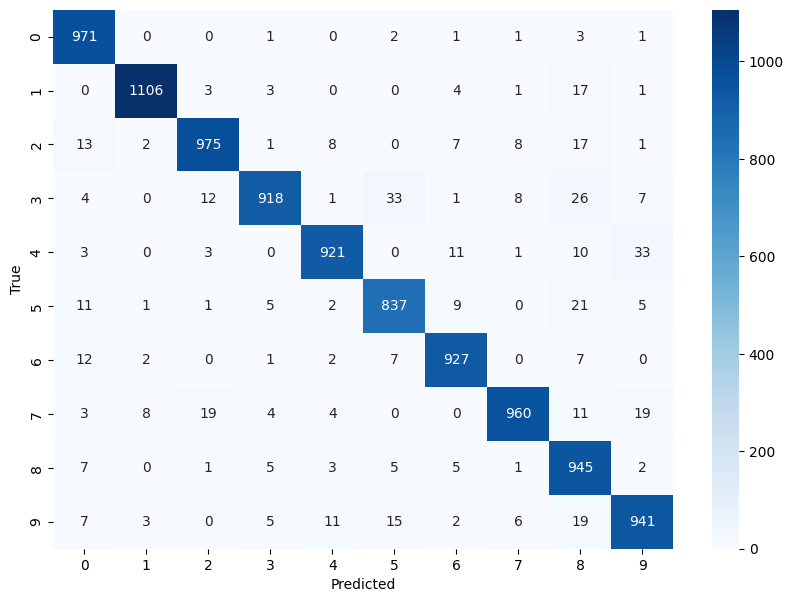

In [16]:
# 7. Generar la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# 8. Mostrar ejemplos de clasificaciones correctas e incorrectas
dataiter = iter(testloader)
images, labels = next(dataiter)  # Cambiado a next(dataiter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

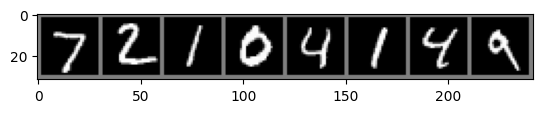

Clasificaciones correctas:  7 2 1 0 4 1 4 9


In [19]:
# Mostrar clasificaciones correctas
correct_idx = np.where(predicted == labels)[0]
imshow(torchvision.utils.make_grid(images[correct_idx[:8]]))
print('Clasificaciones correctas: ', ' '.join(f'{predicted[i].item()}' for i in correct_idx[:8]))

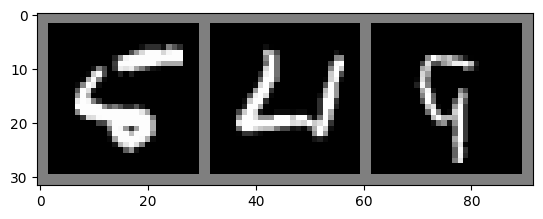

Clasificaciones incorrectas:  Pred: 6, True: 5 Pred: 0, True: 4 Pred: 8, True: 9


In [20]:
# Mostrar clasificaciones incorrectas
incorrect_idx = np.where(predicted != labels)[0]
imshow(torchvision.utils.make_grid(images[incorrect_idx[:8]]))
print('Clasificaciones incorrectas: ', ' '.join(f'Pred: {predicted[i].item()}, True: {labels[i].item()}' for i in incorrect_idx[:8]))

In [ ]:
# 9. Introducción de dropout y regularización (opcional)
class MLPWithDropout(nn.Module):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)  # Dropout con probabilidad del 50%

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Aplicar dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Aplicar dropout
        x = self.softmax(self.fc3(x))
        return x